In [ ]:
import os
import torch
import torch.optim
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
categories = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel',
          'Red Mullet', 'Red Sea Bream', 'Sea Bass',
          'Shrimp', 'Striped Red Mullet', 'Trout']

In [ ]:
PATH = '/content/drive/Shareddrives/COMP576/dataset/Images'
CSV_PATH = "/content/test_data.csv"
MODEL_PATH = "/content/model_weights.pth"

In [ ]:
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
data = pd.read_csv(CSV_PATH)

# Load the weights

In [ ]:
device = torch.device('cuda')
model = models.resnet18()
# testModel.to(device)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 9)

In [ ]:
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

# Define prediction function

In [ ]:
from scipy.special import softmax

def predict(model, test_terns):
    model.eval()   
    predictions = []

    with torch.no_grad():
    # Iterate over data.
        outputs = model(test_terns).detach().cpu().numpy()
        prob = softmax(outputs, axis=1)
        prob = np.max(prob, axis=1)

        preds = outputs.argmax(axis=1)
        predictions.extend(preds)

    return prob, np.array(predictions)

In [ ]:
batch = 500
num_of_batch = int(data.shape[0]//batch) + 1
num_of_batch

2

In [ ]:
labelsPred = []
probs = []
for _ in range(num_of_batch):
    test_terns = []
    for i in range(batch):
        idx = _ * batch + i
        if idx == data.shape[0]:
            break
        img_name = os.path.join(PATH, data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        image = data_transforms(image)
        test_terns.append(image)

    test_fish = torch.stack(test_terns)
    outputs, preds = (predict(model, test_fish))
    for pred, prob in zip(preds, outputs):
        probs.append(prob)
        labelsPred.append(categories[pred])

In [ ]:
data["prob"] = probs
data["predictLabel"] = labelsPred

In [ ]:
falsePred = data[data['trueLabel']!=data['predictLabel']]
truePred = data[data['trueLabel']==data['predictLabel']]

In [ ]:
print("Accuracy in test dataset is: ", 1-(len(falsePred) / len(data)))

Accuracy in test dataset is:  1.0


# Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df_confusion = pd.crosstab(data['trueLabel'], data['predictLabel'])

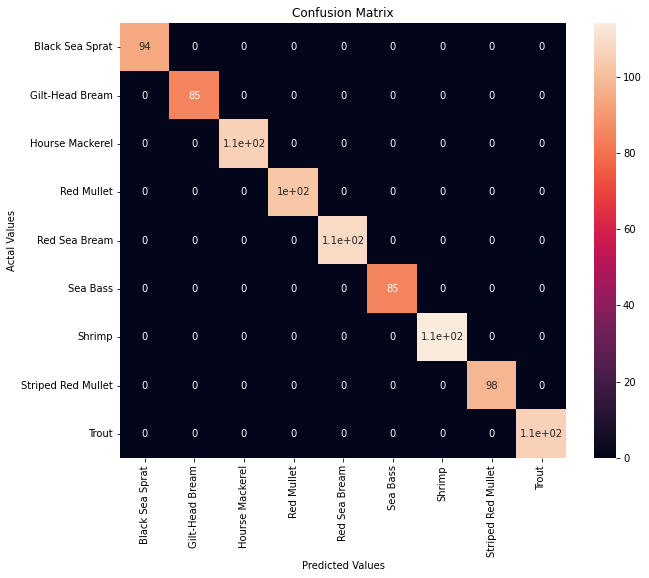

In [ ]:
import seaborn as sns
df_confusion
plt.figure(figsize=(10,8))
sns.heatmap(df_confusion, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Grad Cam

In [ ]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

In [ ]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
target_layers = [model.layer4[-1]]

In [ ]:
columns = 4*2
rows = 5

In [ ]:
def gradCam(specie):
  filenames = truePred[truePred['trueLabel']==specie].sort_values("prob", ascending=False)['filename'].values[:rows*columns//2]
  fig = plt.figure(figsize=(16, 12))
  with EigenGradCAM(model=model, target_layers=target_layers, use_cuda=False) as cam:
      for i in range(1, columns*rows+1, 2):
          path = PATH + "/" + filenames[i//2]
          rgb_img = Image.open(path).convert('RGB')

          img_aft_transform = data_transforms(rgb_img)
          input_tensor = img_aft_transform.unsqueeze(0).float()
          rgb_img_normalize = (img_aft_transform).cpu().detach().numpy()
          rgb_img_normalize = (rgb_img_normalize - np.min(rgb_img_normalize)) / (np.max(rgb_img_normalize) - np.min(rgb_img_normalize))
          rgb_img_normalize = rgb_img_normalize.transpose(1, 2, 0)

          grayscale_cam = cam(input_tensor=input_tensor)

          grayscale_cam = grayscale_cam[0, :]
          visualization = show_cam_on_image(rgb_img_normalize,
                            grayscale_cam, 
                            use_rgb=True)
          cam_img = Image.fromarray(visualization, 'RGB')

          cam_img = cam_img.resize(size=rgb_img.size)
          origin_img = Image.open(path).convert('RGB')

          fig.add_subplot(rows, columns, i)
          plt.imshow(cam_img)
          fig.add_subplot(rows, columns, i+1)
          plt.imshow(origin_img)
  plt.show()
  return fig

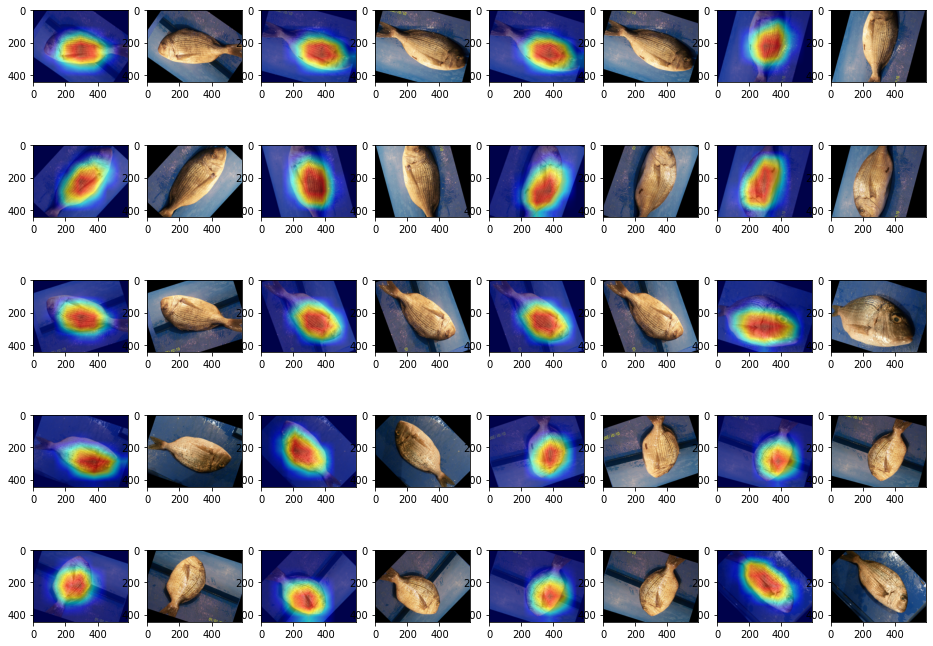

In [ ]:
f = gradCam("Red Sea Bream")

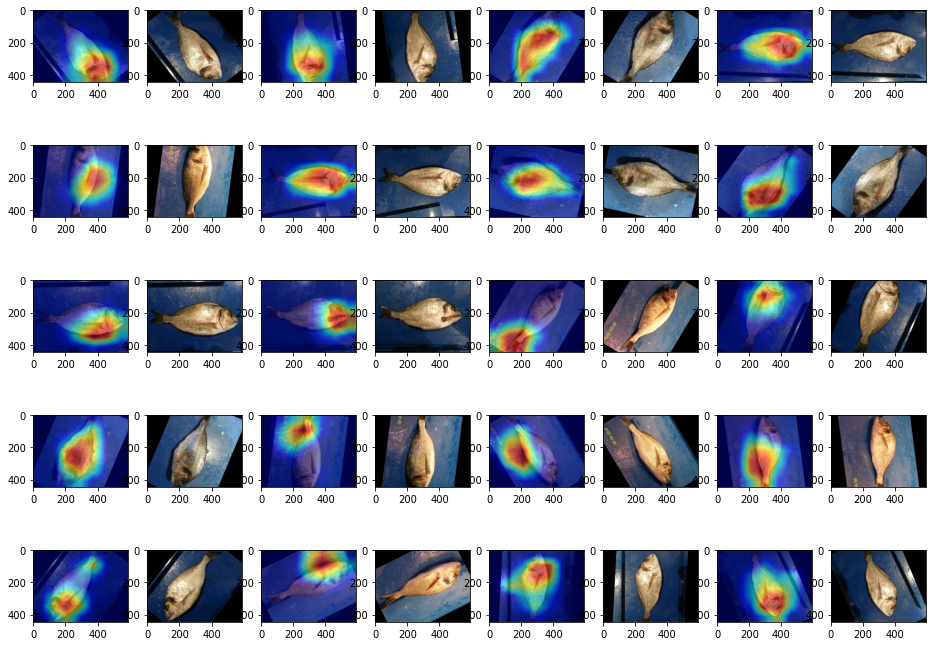

In [ ]:
f = gradCam("Gilt-Head Bream")